# Fast fair regression demo

Copyright 2023 Gradient Institute

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License

## Settings

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


RS = 42

# Classifier RBF Settings
COMPONENTS=500
GAMMA=None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [21]:
from fastfair.datasets import Toy, Communities

#data = Toy(RS)
data = Communities(RS)
X, y, a = data.X, data.y, data.a

X.shape

(1994, 99)

## Measures

In [22]:
# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, log_loss
from sklearn.pipeline import make_pipeline
from fastfair import measures

# Consistent Fold splitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
splits = list(cv.split(X=X, y=a))


# Validate classifier, get held-out predictions, refit on all data
def class_pred(X, Y, n_components=None, gamma=None, C=1., name=""):
    # Instantiate classifier
    if n_components is None:
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
    else:
        if gamma is None:
            gamma = 1. / (X.shape[1] * X.var()) 
        clf = make_pipeline(
            Nystroem(n_components=n_components, gamma=gamma, random_state=RS),
            LogisticRegression(solver="liblinear", max_iter=1000)
        )

    # Cross val predictions
    p = cross_val_predict(clf, X, Y, method="predict_proba", cv=splits)
    
    # Scores
    ll = log_loss(Y, p)
    acc = balanced_accuracy_score(Y, p[:, 1] > 0.5)
    print(f"\t\t{name} log-loss={ll:.4f}, b. accuracy={acc:.4f}")
    return p


def make_classifiers(y, a, s, n_components=None, gamma=None):
    pa_1 = np.mean(a)
    p_a = np.repeat(np.array([[1 - pa_1, pa_1]]), len(a), axis=0)
    sy = np.vstack((y, s)).T
    p_y = class_pred(y[:, np.newaxis], a, n_components, gamma, name="P(A|Y)")
    p_s = class_pred(s[:, np.newaxis], a, n_components, gamma, name="P(A|S)")
    p_sy = class_pred(sy, a, n_components, gamma, name="P(A|S, Y)")
    return p_a, p_y, p_s, p_sy


def compute_mi_measures(p_a, p_y, p_s, p_sy, a, normalise=True):
    ind = measures.cmi(p_s, p_a, a, normalise)
    sep = measures.cmi(p_sy, p_y, a, normalise)
    suf = measures.cmi(p_sy, p_s, a, normalise)
    return ind, sep, suf

## See how well $Y$ predicts $A$

For the separation and sufficiency measures.

There may not be much difference between separation and independence if $Y$ is not predictive of $A$

We should also test how much more predictive of $A$ $X$ is with $Y$.

		P(A|Y) log-loss=0.2537, b. accuracy=0.6351
		P(A|X) log-loss=0.0982, b. accuracy=0.8668
		P(A|Y, X) log-loss=0.0985, b. accuracy=0.8686


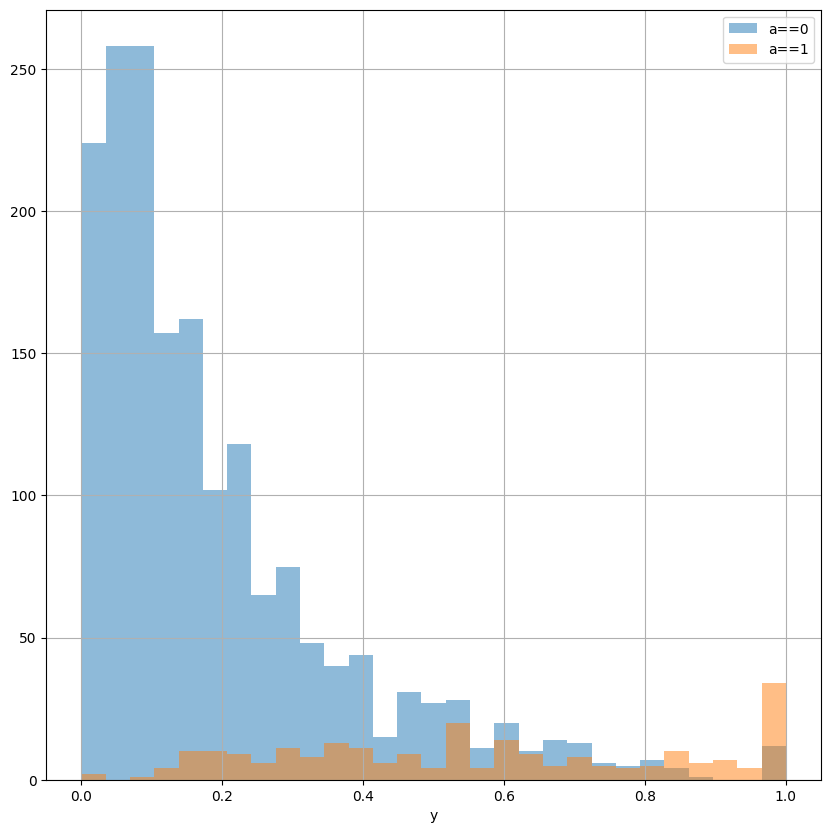

In [23]:
class_pred(y[:, np.newaxis], a, COMPONENTS, GAMMA, name="P(A|Y)");
class_pred(X, a, COMPONENTS, GAMMA, name="P(A|X)");
class_pred(np.hstack((X, y[:, np.newaxis])), a, COMPONENTS, GAMMA, name="P(A|Y, X)");

plt.figure(figsize=(10, 10))
bins = np.linspace(y.min(), y.max(), 30)
plt.hist(y[a==0], bins=bins, label="a==0", alpha=0.5)
plt.hist(y[a==1], bins=bins, label="a==1", alpha=0.5)
plt.grid()
plt.xlabel("y")
plt.legend()
plt.show()

## Test Regressor
Just to benchmark our implementation...

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

#base = RandomForestRegressor()
base = Ridge(alpha=1.)
#base = make_pipeline(
    #RBFSampler(n_components=10000, gamma=.1),
#    Ridge(alpha=1.)
#)

s = cross_val_predict(base, X, y, cv=splits)
r2_base = r2_score(y, s)
rmse_base = np.sqrt(mean_squared_error(y, s))
print(f"base regressor: r2={r2_base:.3f}, rmse={rmse_base:.3f}")

plt.figure(figsize=(10, 10))
bins = np.linspace(y.min(), y.max(), 30)
plt.plot(y[a==0], s[a==0], '.', label="a==0")
plt.plot(y[a==1], s[a==1], '.', label="a==1")
plt.grid()
plt.xlabel("y")
plt.ylabel("s")
plt.legend()
plt.show()

## Test loop

In [ ]:
from fastfair.models import LSPCIndependence, LSPCSeparation, LSPCSufficiency

# model dicts
models = {
    "indep": LSPCIndependence,
    "separ": LSPCSeparation,
    "suffi": LSPCSufficiency
}

# fairness regulariser settings
lambda_w = 0.00
lambda_f = np.linspace(0, 2.0, 5)
results = {k: [] for k in models.keys()}

# Cross val loops
for lf in lambda_f:
    print(f"Regulariser: {lf}")
    for name, model in models.items():
        mod = model(lambda_w=lambda_w, lambda_f=lf, random_state=RS)
        s = cross_val_predict(mod, X, y, fit_params={"a": a}, cv=splits)
        
        # Performance measures
        res = {}
        res["r2"] = r2_score(y, s)
        res["rmse"] = np.sqrt(mean_squared_error(y, s))
        
        # Fairness measures
        p_a, p_y, p_s, p_sy = make_classifiers(y, a, s, n_components=COMPONENTS, gamma=GAMMA)
        res["ind"], res["sep"], res["suf"] = compute_mi_measures(p_a, p_y, p_s, p_sy, a)
        
        # Print results
        resstr = " ".join(["{}={:.3f}".format(k, v) for k, v in res.items()])
        print(f"\t{name}: {resstr}")
        
        results[name].append(res)

## Plot results

In [ ]:
plots = ["r2", "ind", "sep", "suf"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for res, ax in zip(plots, np.ravel(axes)):
    ax.set_title(res)
    ax.set_xlabel("$\lambda_f$")
    ax.set_ylabel(res)
    
    for name, resarr in results.items():
        # unpack
        r_arr = [r[res] for r in resarr]
        ax.plot(lambda_f, r_arr, label=name + ". regularised")
    
    ax.legend()
    ax.grid()
    
plt.show()